In [1]:
import h5py
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import itertools 
import pyts
from pyts.approximation import PiecewiseAggregateApproximation

from sklearn.utils import class_weight

import pathlib
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, optimizers
from tensorflow.keras.layers import Convolution2D,Conv2D, Dense,Dropout, Flatten, Activation, MaxPooling2D, Input, Conv1D, GlobalAveragePooling1D, TimeDistributed, GRU, LSTM

print(tf.__version__)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
gpus = tf.config.experimental.list_physical_devices('GPU')

try:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
except RuntimeError as e:
    print(e)

2022-02-19 04:21:40.801730: I tensorflow/stream_executor/platform/default/dso_loader.cc:54] Successfully opened dynamic library libcudart.so.11.0


2.5.0
Num GPUs Available:  1


2022-02-19 04:21:42.228686: I tensorflow/stream_executor/platform/default/dso_loader.cc:54] Successfully opened dynamic library libcuda.so.1
2022-02-19 04:21:42.287324: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1734] Found device 0 with properties: 
pciBusID: 0000:21:00.0 name: NVIDIA GeForce RTX 2080 Ti computeCapability: 7.5
coreClock: 1.545GHz coreCount: 68 deviceMemorySize: 10.76GiB deviceMemoryBandwidth: 573.69GiB/s
2022-02-19 04:21:42.287382: I tensorflow/stream_executor/platform/default/dso_loader.cc:54] Successfully opened dynamic library libcudart.so.11.0
2022-02-19 04:21:42.304996: I tensorflow/stream_executor/platform/default/dso_loader.cc:54] Successfully opened dynamic library libcublas.so.11
2022-02-19 04:21:42.305078: I tensorflow/stream_executor/platform/default/dso_loader.cc:54] Successfully opened dynamic library libcublasLt.so.11
2022-02-19 04:21:42.312602: I tensorflow/stream_executor/platform/default/dso_loader.cc:54] Successfully opened dynamic library li

In [2]:
from os import environ
dataset = environ['dataset']
print(dataset)

refit_gen_GASF_60m_300S0X_15A157030N_R42_80-20-V1


In [3]:
#my defs 
from modules.models import  VGG11,LSTM_3D_V56,CNN_V56,LSTM_BI_V56
from modules.tools import my_print, plot_confusion_matrix_norm, get_data,get_data_split, evaluate_model, create_tl_model
from modules.HDF5ImageGenerator import HDF5ImageGenerator

In [4]:
#LOAD DATASET
#file_name = "ukdale_gen_GASF_13m_100S5X12A54480"
#file_name = "refit_gen_GASF_13m_100S5X_15A166006"
file_name = "refit_gen_GASF_13m_100S5X_15A166006_R42-80-20"
#file_name = "refit_gen_GASF_13m_100S5X_15A166006_R42_80-20"
file_name = "refit_gen_GASF_60m_300S0X_15A157030N_R12_80-20-V1"
file_name = environ["dataset"]
#read the file
path = str(pathlib.Path().resolve())

path_data = f"{path}""/data/"f"{file_name}""/"f"{file_name}"".hdf5"

file = h5py.File(path_data,"r+")

In [5]:
x_test,y_test,d_class_weights,num_of_classes,appliances = get_data(file)

['HEKA', 'fridge/freezer', 'audio system', 'breadmaker', 'broadband router', 'computer', 'dehumidifier', 'dish washer', 'electric space heater', 'food processor', 'pond pump', 'television', 'tumble dryer', 'washer dryer', 'washing machine']
{0: 0.2602198297365584, 1: 0.40103670634920635, 2: 2.4953395061728396, 3: 8.651578384162654, 4: 8.369461697722567, 5: 0.8347426565484487, 6: 8.421770833333333, 7: 0.863218022635063, 8: 4.254091028676664, 9: 8.10516290726817, 10: 8.421770833333333, 11: 0.4771541548630784, 12: 1.9194919278252611, 13: 4.587177304964539, 14: 0.4462973696558196}
 
Tests 
HEKA test: 5178 train: 20713
fridge/freezer test: 3360 train: 13440
audio system test: 540 train: 2160
breadmaker test: 156 train: 623
broadband router test: 161 train: 644
computer test: 1614 train: 6457
dehumidifier test: 160 train: 640
dish washer test: 1561 train: 6244
electric space heater test: 317 train: 1267
food processor test: 166 train: 665
pond pump test: 160 train: 640
television test: 2824 

In [6]:
def select_model(learn_type):
    
    if learn_type == "CNN":
        model = CNN_V56(file["data/train/gaf"][0:10],num_of_classes,lr= 0.00002)

    if learn_type == "LSTM":
        model = LSTM_3D_V56(file["data/train/gaf"][0:10],num_of_classes,lr= 0.00002)

    if learn_type == "BI_LSTM":
        model = LSTM_BI_V56(file["data/train/gaf"][0:10],num_of_classes,lr= 0.00002)
        
    if learn_type == "VGG":
        model = VGG11(file["data/train/gaf"][0:10],num_of_classes,lr= 0.00001)

    return model
              

In [7]:
path_save = path+'/experiment_automation/output/'+environ['learn_type']+'/'+dataset.split("_")[0]+"/"+environ['train_type']+"/"+dataset.split("_")[0]+"_"+environ['seed']+"_"+environ['tl_datasets']
path_save_nb = path_save+"_out.ipynb"
path_save_log = path_save+"_out_log2.txt"

In [8]:
from keras.callbacks import LambdaCallback
#path_log= path+'/experiment_automation/output/'+environ['learn_type']+'/'+dataset.split("_")[0]+"/"+environ['train_type']+"/"+dataset.split("_")[0]+"_"+environ['seed']+"_"+environ['tl_datasets']+"_log.txt"
txt_log = open(path_save+"_log.txt", mode='wt', buffering=1)
txt_log.write("file created! \n")

save_op_callback = LambdaCallback(
  on_epoch_end = lambda epoch, logs: txt_log.write(
    str({'epoch': epoch, 'loss': logs['loss'],'acc': logs['accuracy']}) + '\n'),
                                                           
)

In [9]:
print(path_save_nb)

/workspace/notebooks/experiment_automation/output/VGG/refit/BB/refit_42__out.ipynb


In [10]:
# rm $path_save_log

In [11]:
# %%capture cap 

# with open(path_save_log,"wt") as f:
#     f.write(cap.stdout)
    
# print("out capture..")

Normal way
[0 1 2 3 4 5 6 7 8 9]
Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.


2022-02-19 04:21:52.725335: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1734] Found device 0 with properties: 
pciBusID: 0000:21:00.0 name: NVIDIA GeForce RTX 2080 Ti computeCapability: 7.5
coreClock: 1.545GHz coreCount: 68 deviceMemorySize: 10.76GiB deviceMemoryBandwidth: 573.69GiB/s
2022-02-19 04:21:52.727050: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1872] Adding visible gpu devices: 0
2022-02-19 04:21:52.727357: I tensorflow/stream_executor/platform/default/dso_loader.cc:54] Successfully opened dynamic library libcudart.so.11.0
2022-02-19 04:21:53.591685: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1258] Device interconnect StreamExecutor with strength 1 edge matrix:
2022-02-19 04:21:53.591721: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1264]      0 
2022-02-19 04:21:53.591754: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1277] 0:   N 
2022-02-19 04:21:53.592431: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1418] Created TensorFlow device 

Epoch 1/100


2022-02-19 04:21:53.800697: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 3299990000 Hz
2022-02-19 04:21:54.475203: I tensorflow/stream_executor/platform/default/dso_loader.cc:54] Successfully opened dynamic library libcudnn.so.8
2022-02-19 04:21:55.234881: I tensorflow/stream_executor/cuda/cuda_dnn.cc:380] Loaded cuDNN version 8202
2022-02-19 04:21:56.144770: I tensorflow/stream_executor/platform/default/dso_loader.cc:54] Successfully opened dynamic library libcublas.so.11
2022-02-19 04:21:56.937691: I tensorflow/stream_executor/platform/default/dso_loader.cc:54] Successfully opened dynamic library libcublasLt.so.11


2527/2527 - 519s - loss: 2.3235 - accuracy: 0.3137
Epoch 2/100
2527/2527 - 515s - loss: 1.6630 - accuracy: 0.5156
Epoch 3/100
2527/2527 - 514s - loss: 1.2875 - accuracy: 0.5770
Epoch 4/100
2527/2527 - 517s - loss: 1.1261 - accuracy: 0.6166
Epoch 5/100
2527/2527 - 515s - loss: 0.9895 - accuracy: 0.6470
Epoch 6/100
2527/2527 - 513s - loss: 0.9005 - accuracy: 0.6680
Epoch 7/100
2527/2527 - 513s - loss: 0.7952 - accuracy: 0.6973
Epoch 8/100
2527/2527 - 513s - loss: 0.7414 - accuracy: 0.7091
Epoch 9/100
2527/2527 - 514s - loss: 0.6583 - accuracy: 0.7317
Epoch 10/100
2527/2527 - 513s - loss: 0.6046 - accuracy: 0.7478
Epoch 11/100
2527/2527 - 513s - loss: 0.5531 - accuracy: 0.7629
Epoch 12/100
2527/2527 - 513s - loss: 0.5247 - accuracy: 0.7731
Epoch 13/100
2527/2527 - 513s - loss: 0.4704 - accuracy: 0.7911
Epoch 14/100
2527/2527 - 516s - loss: 0.4392 - accuracy: 0.8017
Epoch 15/100
2527/2527 - 514s - loss: 0.4042 - accuracy: 0.8171
Epoch 16/100
2527/2527 - 514s - loss: 0.3716 - accuracy: 0.82

2022-02-19 18:39:32.348325: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: /workspace/notebooks/models/VGG/refit_42/assets


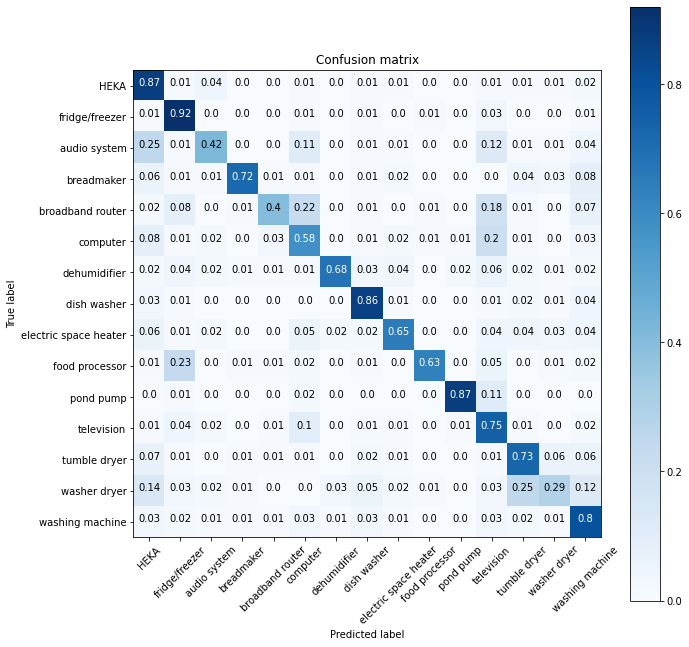

In [12]:
# %%capture cap --no-stderr


if environ['train_type'] == "BB":

    #define generator
    train_gen = HDF5ImageGenerator(
        src= path_data,
        X_key="data/train/gaf",
        y_key="labels/train/gaf",
        classes_key="appliances/classes",
        labels_encoding="hot",
        shuffle=True,
        batch_size=int(environ['batch_size']),
        num_classes=num_of_classes,
        mode="train",
        )
    
    model = select_model(environ['learn_type'])
    
    txt_log.write("fitting BB model: \n")
    
    model.fit(
        train_gen,
        verbose=2,
        epochs=int(environ['epochs']),
        class_weight=d_class_weights,
        callbacks = [save_op_callback],
    )
    
    txt_log.write("finished fitting BB model: \n")

    evaluate_model(model,x_test,y_test,appliances)
    
    if environ['save_model']=="True":

        path_model_save = path+"/models/"+environ['learn_type']+"/"+dataset.split("_")[0]+"_"+dataset.split("_R")[1][0:2]
        model.save(path_model_save)
        txt_log.write("model saved to:"+"/models/"+environ['learn_type']+"/"+dataset.split("_")[0]+"_"+dataset.split("_R")[1][0:2]+" \n")
        
        
# with open(path_save+"_out_log.txt" as f:
#     f.write(cap.stdout)


In [13]:
#model = keras.models.load_model(path_model1)
# model_used = model

In [14]:
# evaluate_model(model,x_test,y_test,appliances)

In [15]:
# datasets =[
#     "ukdale_gen_GASF_13m_100S5X12A54480_R82_80-20"
# ]

if environ['train_type'] == "TL": 
    models = environ['tl_datasets'].replace(" ","").split(",")
    #model = ["base"]
    
    for model in models:
    
        file_name = dataset
        
        datasetTL = model
        
        seed = dataset.split("_R")[1][0:2]
        
        print("using dataset data",dataset.split("_")[0],"training on model",model,"seed",environ['seed'])
        txt_log.write("starting "+dataset.split("_")[0]+" training on model "+model+" seed "+environ['seed']+"\n")


        tf.keras.backend.clear_session()


        #read the file
        path = str(pathlib.Path().resolve())
        path_data = f"{path}""/data/"f"{file_name}""/"f"{file_name}"".hdf5"
        file = h5py.File(path_data,"r+")


        print("reading data, printing stats: ")
        x_test,y_test,d_class_weights,num_of_classes,appliances = get_data(file)
        print("loading model")
        
        model_seed = 42
        model_used = create_tl_model(model,environ['learn_type'],model_seed,path,num_of_classes)
                
        train_gen = HDF5ImageGenerator(
            src= path_data,
            X_key="data/train/gaf",
            y_key="labels/train/gaf",
            classes_key="appliances/classes",
            labels_encoding="hot",
            shuffle=True,
            batch_size=int(environ['batch_size']),
            num_classes=num_of_classes,
            mode="train",
            )

        model_used.fit(
            train_gen,
            verbose=2,
            epochs=int(environ['epochs']),
            class_weight=d_class_weights,
            callbacks = [save_op_callback]
            #workers = 6,
        )
        
        txt_log.write("finished "+dataset.split("_")[0]+" training on model "+model+" seed "+environ['seed']+"\n")


        evaluate_model(model_used,x_test,y_test,appliances)
        



        #del model_used



In [16]:
txt_log.close()